# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat  PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [293]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import astropy
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import optimize
from scipy.stats import uniform, norm
## Read in data
from astropy.io import ascii
data_1 = ascii.read('PS1_PS1MD_PSc000098.snana.dat',delimiter=' ',header_start=11,data_end=401)
data_2 = ascii.read('PS1_PS1MD_PSc000174.snana.dat',delimiter=' ',header_start=11,data_end=401)          

In [310]:
## Write some functions to implement the model, likelihood and priors, and use emcee to sample the posterior with 20 walkers 
## and however many steps you feel is necessary for the burn-in and chain. 

## Get flux from mag

def flux_from_mag(mag,flux_0):
    return flux_0*10**(-(mag-0.0127)/2.5)

## Function for model

def villar_model(t,A,beta,t_0,gamma,t_rise,t_fall): ## From Villar et al. (2019), eq'n 1
    flux = np.where(t<(gamma+t_0),(A+beta*(t-t_0))/(1+np.exp(-(t-t_0)/t_rise)), 
                    (A+beta*(gamma))*np.exp(-(t-gamma-t_0)/t_fall)/(1+np.exp(-(t-t_0)/t_rise))) # +c
    return flux

#def N(int1,int2):
   # return: 
    
def log_prior(data,A,beta,t_0,gamma,t_rise,t_fall):
    
    sigma=data['MAGERR']
    Fmin=np.min(-data['MAG']) 
    Fmax=np.max(-data['MAG'])
    tmax = np.max(data['MJD'])
    tmin = np.min(data['MJD'])
    
    ## All priors are a uniform distribution - From Villar et al. (2019), table 1
    if (A>100*Fmax or A<3*np.mean(sigma)) or\
    (beta>0 or beta<-Fmax/15) or\
    (t_0>tmax+300 or t_0<tmin-50) or\
    (gamma>1400 or gamma<1) or\
    (t_rise>50 or t_rise<0.01) or\
    (t_fall>300 or t_fall<1): #or\
        return -np.inf
    
    p_A = uniform.pdf(A,loc=5.3,scale=1.) ## Amplitude 
    p_beta = uniform.pdf(beta,loc=-.02,scale=1.) ## Plateau slope
    p_t_0 = uniform.pdf(t_0,loc=55200,scale=10.) ## Start time
    p_gamma = (2/3)*norm.pdf(gamma,scale=(5,5)) + (1/3)*norm.pdf(gamma,scale=(60, 30))#norm.pdf(gamma,loc=100,scale=1.) ## Plateau duration, t_1-t_0
    p_t_rise = uniform.pdf(t_rise,loc=5,scale=1.) ## Rise time
    p_t_fall = uniform.pdf(t_fall,loc=100,scale=1.) ## Decline time
    
    return np.log(p_A*p_beta*p_t_0*p_gamma*p_t_rise*p_t_fall)

def log_likelihood(data,t,A,beta,t_0,gamma,t_rise,t_fall,flux, sigma):
    flux = -data['MAG']
    model = villar_model(data['MJD'],A,beta,t_0,gamma,t_rise,t_fall)
    sigma = data['MAGERR']
    return np.sum((flux-model)**2/2*sigma**2)

def log_posterior(params, data=None, t=None, flux=None, sigma=None): ## From emcee_full_example
    A,beta,t_0,gamma,t_rise,t_fall = params
    lnlike = log_likelihood(data,t,A,beta,t_0,gamma,t_rise,t_fall, flux, sigma)
    lnprior = log_prior(data,A,beta,t_0,gamma,t_rise,t_fall)
    lnposterior = lnlike + lnprior
    return lnposterior


/tmp/ipykernel_212901/3980185630.py:12: RuntimeWarning: overflow encountered in exp
  flux = np.where(t<(gamma+t_0),(A+beta*(t-t_0))/(1+np.exp(-(t-t_0)/t_rise)),
/tmp/ipykernel_212901/3980185630.py:13: RuntimeWarning: overflow encountered in exp
  (A+beta*(gamma))*np.exp(-(t-gamma-t_0)/t_fall)/(1+np.exp(-(t-t_0)/t_rise))) # +c


Text(0.5, 1.0, 'g-band data')

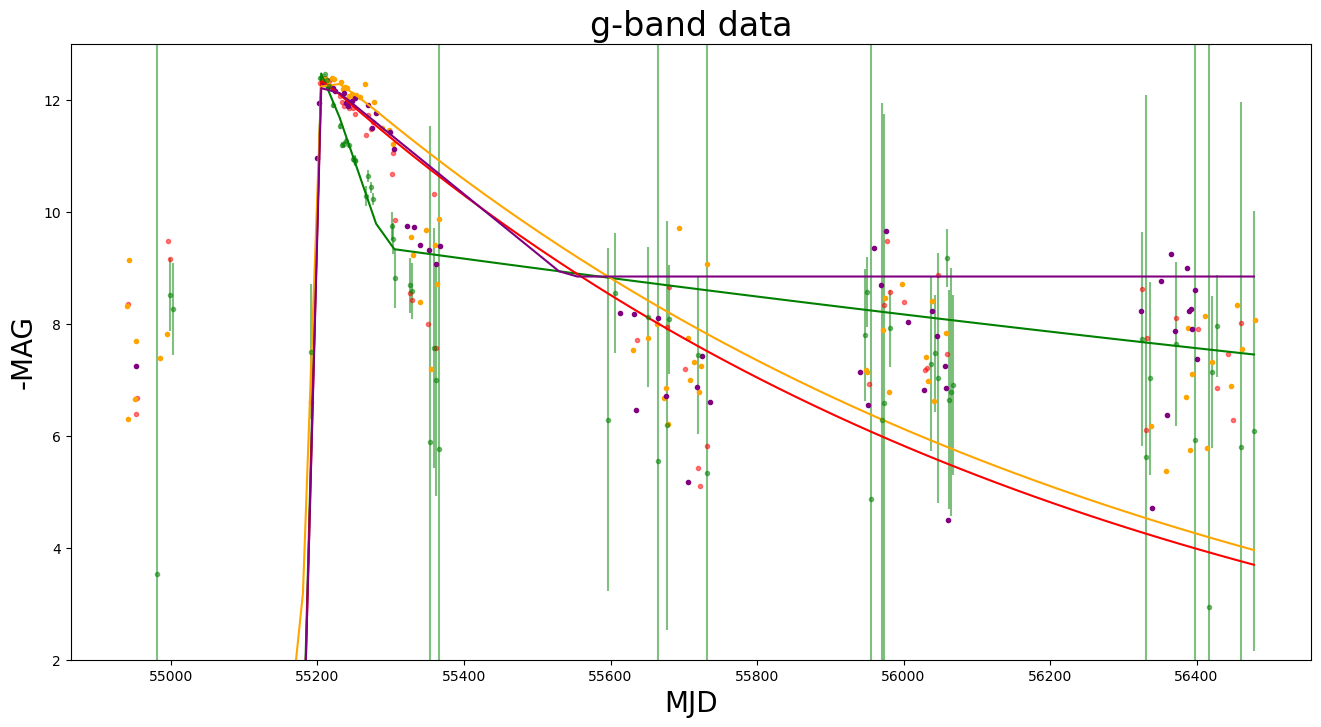

In [315]:
## Separate data into bands b/c I don't feel like typing all that every time

data_1_g = np.array(data_1[data_1['FLT']=='g'])[~np.isnan(data_1[data_1['FLT']=='g']['MAG'])]
data_1_r = data_1[data_1['FLT']=='r'][~np.isnan(data_1[data_1['FLT']=='r']['MAG'])]
data_1_i = data_1[data_1['FLT']=='i'][~np.isnan(data_1[data_1['FLT']=='i']['MAG'])]
data_1_z = data_1[data_1['FLT']=='z'][~np.isnan(data_1[data_1['FLT']=='z']['MAG'])]

t = np.linspace(np.min(data_1_g['MJD']),np.max(data_1_g['MJD']),len(data_1_g['MJD']))

## Scipy optimization for first guesses

import scipy

init_g = scipy.optimize.curve_fit(villar_model,data_1_g['MJD'],-data_1_g['MAG'],p0=np.array([5.3,-.02,55200,100,5,100]),sigma=data_1_g['MAGERR'])
init_r = scipy.optimize.curve_fit(villar_model,data_1_r['MJD'],-data_1_r['MAG'],p0=np.array([5.3,-.02,55200,100,5,100]),sigma=data_1_r['MAGERR'])
init_i = scipy.optimize.curve_fit(villar_model,data_1_i['MJD'],-data_1_i['MAG'],p0=np.array([5.3,-.02,55200,100,5,100]),sigma=data_1_i['MAGERR'])
init_z = scipy.optimize.curve_fit(villar_model,data_1_z['MJD'],-data_1_z['MAG'],p0=np.array([5.3,-.02,55200,100,5,100]),sigma=data_1_z['MAGERR'])
                                                                  
plt.figure(figsize=(16,8))
plt.errorbar(data_1_g['MJD'],-data_1_g['MAG'],yerr=data_1_g['MAGERR'],fmt='.',color='g',alpha=0.5)
plt.plot(data_1_r['MJD'],-data_1_r['MAG'],'.',color='r',alpha=0.5)
plt.plot(data_1_i['MJD'],-data_1_i['MAG'],'.',color='orange')
plt.plot(data_1_z['MJD'],-data_1_z['MAG'],'.',color='purple')
plt.ylim(2,13)
plt.plot(t,villar_model(t,init_g[0][0],init_g[0][1],init_g[0][2],init_g[0][3],init_g[0][4],init_g[0][5]),color='green',label='Scipy')
plt.plot(t,villar_model(t,init_r[0][0],init_r[0][1],init_r[0][2],init_r[0][3],init_r[0][4],init_r[0][5]),color='red',label='Scipy')
plt.plot(t,villar_model(t,init_i[0][0],init_i[0][1],init_i[0][2],init_i[0][3],init_i[0][4],init_i[0][5]),color='orange',label='Scipy')
plt.plot(t,villar_model(t,init_z[0][0],init_z[0][1],init_z[0][2],init_z[0][3],init_z[0][4],init_z[0][5]),color='purple',label='Scipy')

#plt.legend(loc='lower left',fontsize=16)
plt.xlabel('MJD',fontsize=20)
plt.ylabel('-MAG',fontsize=20)
plt.title('g-band data',fontsize=24)

In [322]:
## Initial params
from tqdm import tqdm

n_walkers = 20
n_dim = 6
n_burn = 1000

guess_init_g = np.array([init_g[0][0],init_g[0][1],init_g[0][2],init_g[0][3],init_g[0][4],init_g[0][5]]) + 0.1*np.mean(data_1['MAGERR'])*np.random.randn(n_walkers, n_dim)
guess_init_r = np.array([init_r[0][0],init_r[0][1],init_r[0][2],init_r[0][3],init_r[0][4],init_r[0][5]]) + 0.1*np.mean(data_1['MAGERR'])*np.random.randn(n_walkers, n_dim)
guess_init_i = np.array([init_i[0][0],init_i[0][1],init_i[0][2],init_i[0][3],init_i[0][4],init_i[0][5]]) + 0.1*np.mean(data_1['MAGERR'])*np.random.randn(n_walkers, n_dim)
guess_init_z = np.array([init_z[0][0],init_z[0][1],init_z[0][2],init_z[0][3],init_z[0][4],init_z[0][5]]) + 0.1*np.mean(data_1['MAGERR'])*np.random.randn(n_walkers, n_dim)

## Run emcee

sampler_g = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, kwargs={'data':data_1_g,'t':data_1_g['MJD']})
state = sampler_g.run_mcmc(guess_init_g, n_burn, skip_initial_state_check=True) 
sampler_g.run_mcmc(state, 10000, progress=True, skip_initial_state_check=True)

sampler_r = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, kwargs={'data':data_1_r,'t':data_1_r['MJD']})
state = sampler_r.run_mcmc(guess_init_r, n_burn, skip_initial_state_check=True) 
sampler_r.run_mcmc(state, 10000, progress=True, skip_initial_state_check=True)

sampler_i = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, kwargs={'data':data_1_i,'t':data_1_i['MJD']})
state = sampler_i.run_mcmc(guess_init_i, n_burn, skip_initial_state_check=True) 
sampler_i.run_mcmc(state, 10000, progress=True, skip_initial_state_check=True)

sampler_z = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, kwargs={'data':data_1_z,'t':data_1_z['MJD']})
state = sampler_z.run_mcmc(guess_init_z, n_burn, skip_initial_state_check=True) 
sampler_z.run_mcmc(state, 10000, progress=True, skip_initial_state_check=True);


You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee


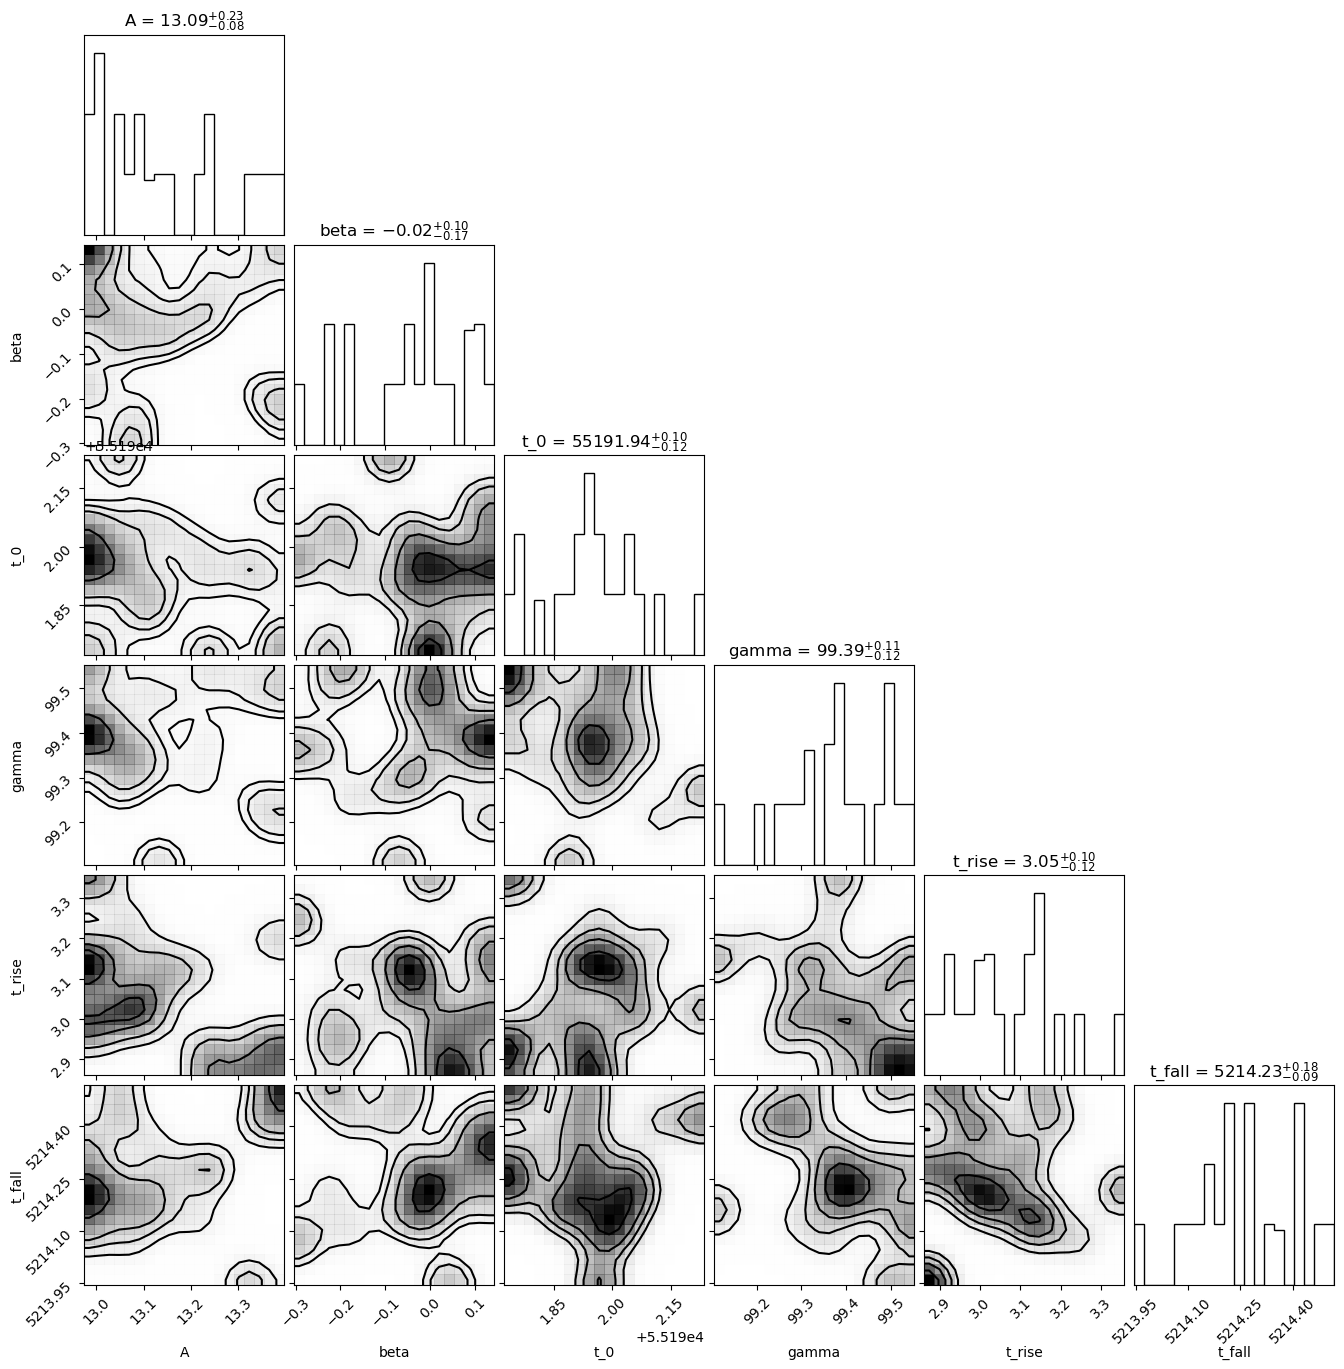

In [323]:
## Show that the posterior is reasonable by generating a corner plot with the corner package. 

## None of these values are good!

sample_g = sampler_g.chain
sample_g = sampler_g.chain[:, 1000:, :].reshape(-1, n_dim)
labels= ['A','beta','t_0','gamma','t_rise','t_fall']
fig = corner.corner(sample_g[1000::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)

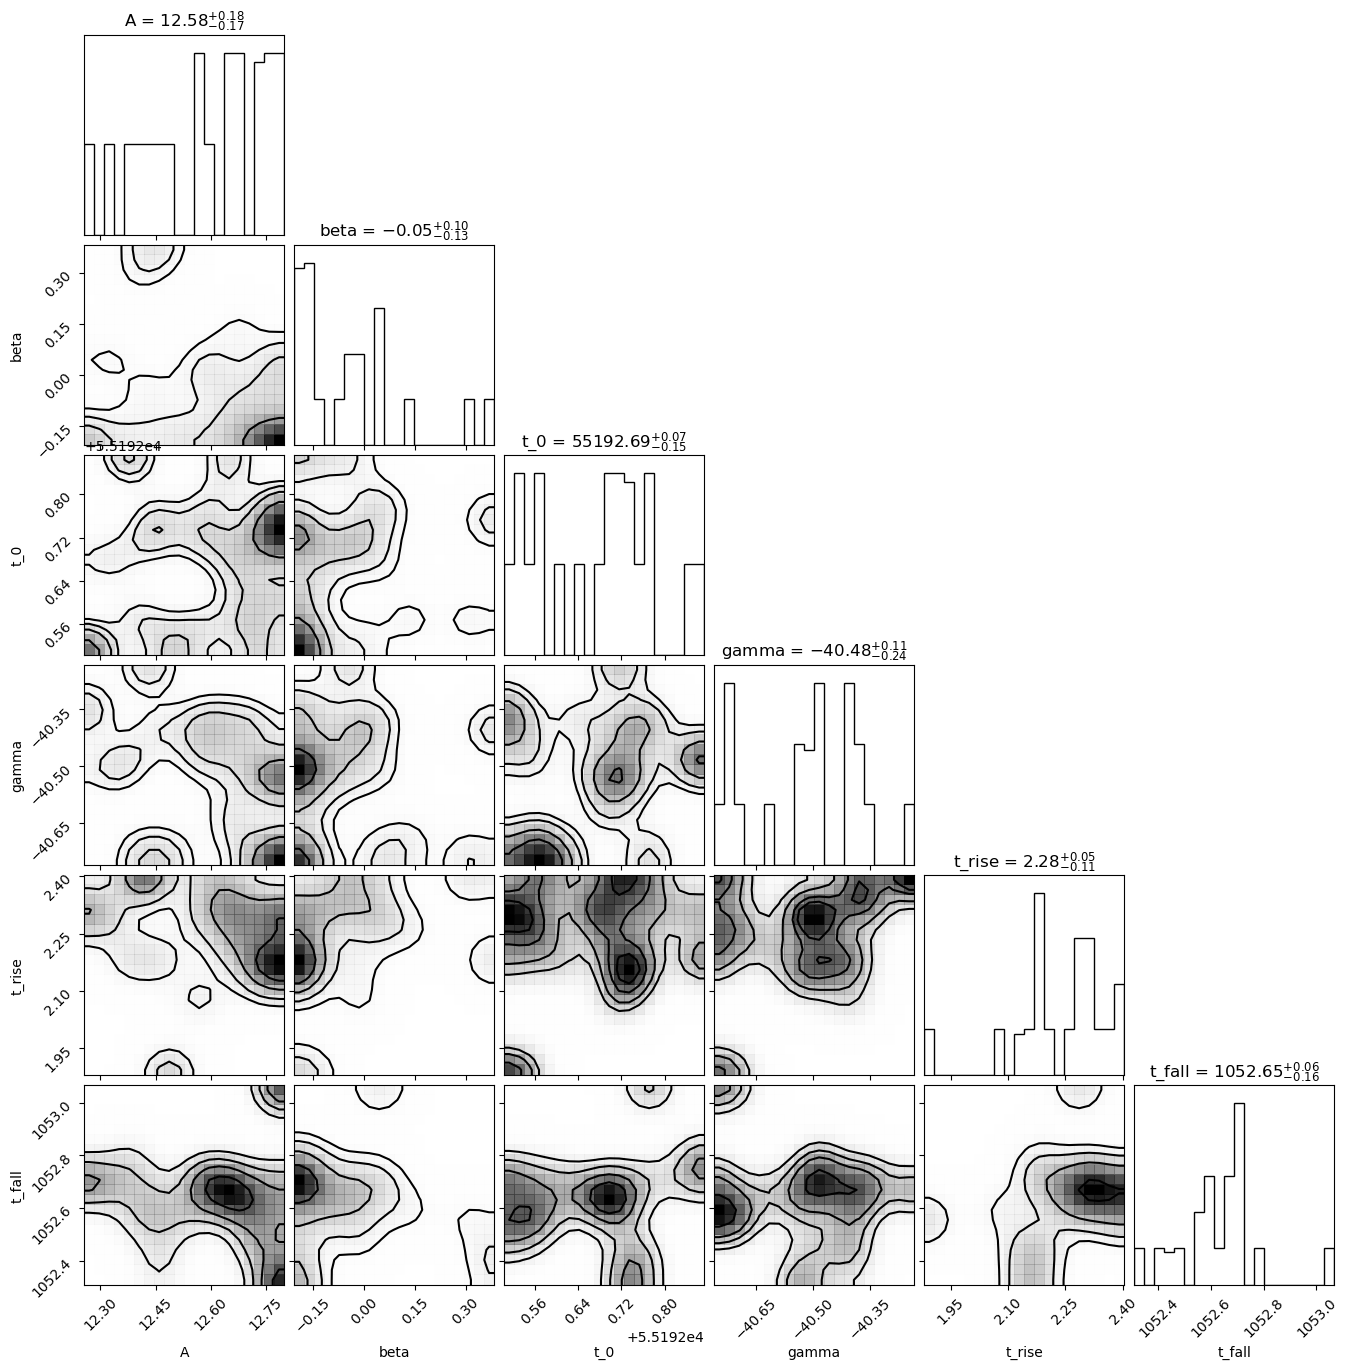

In [324]:
sample_r = sampler_r.chain
sample_r = sampler_r.chain[:, 1000:, :].reshape(-1, n_dim)
labels= ['A','beta','t_0','gamma','t_rise','t_fall']
fig = corner.corner(sample_r[1000::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)

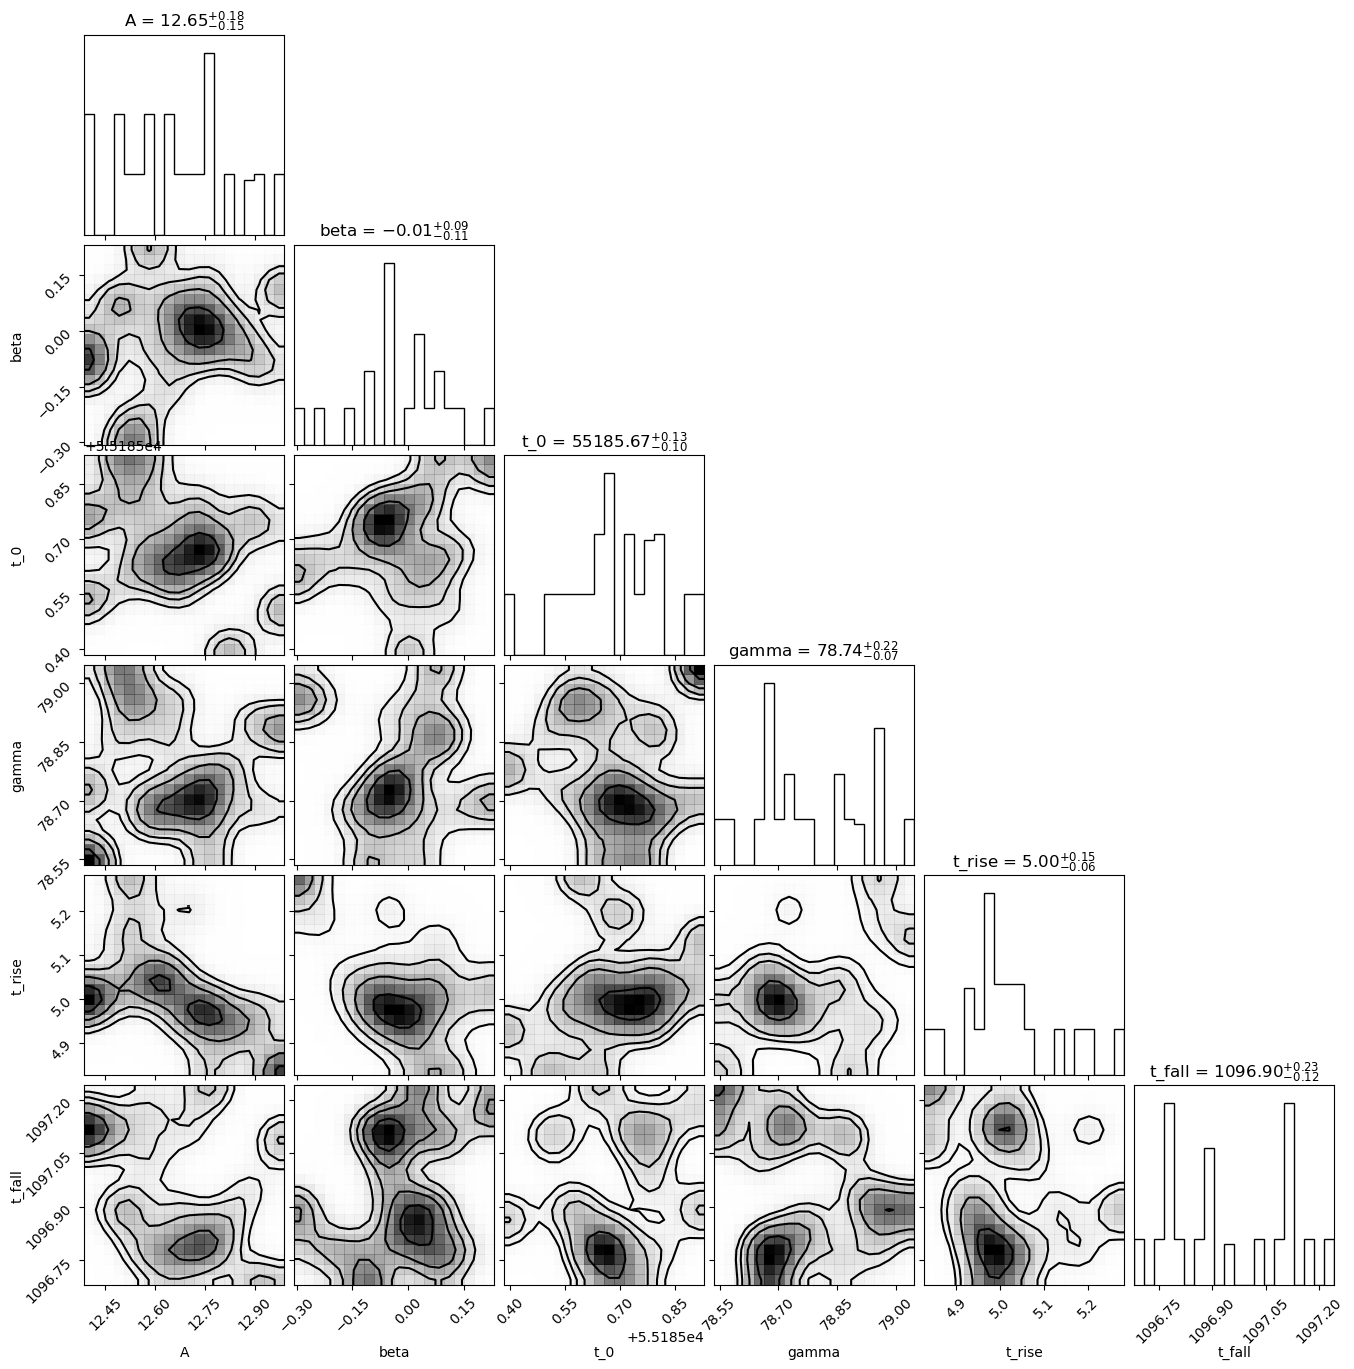

In [325]:
sample_i = sampler_i.chain
sample_i = sampler_i.chain[:, 1000:, :].reshape(-1, n_dim)
labels= ['A','beta','t_0','gamma','t_rise','t_fall']
fig = corner.corner(sample_i[1000::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)

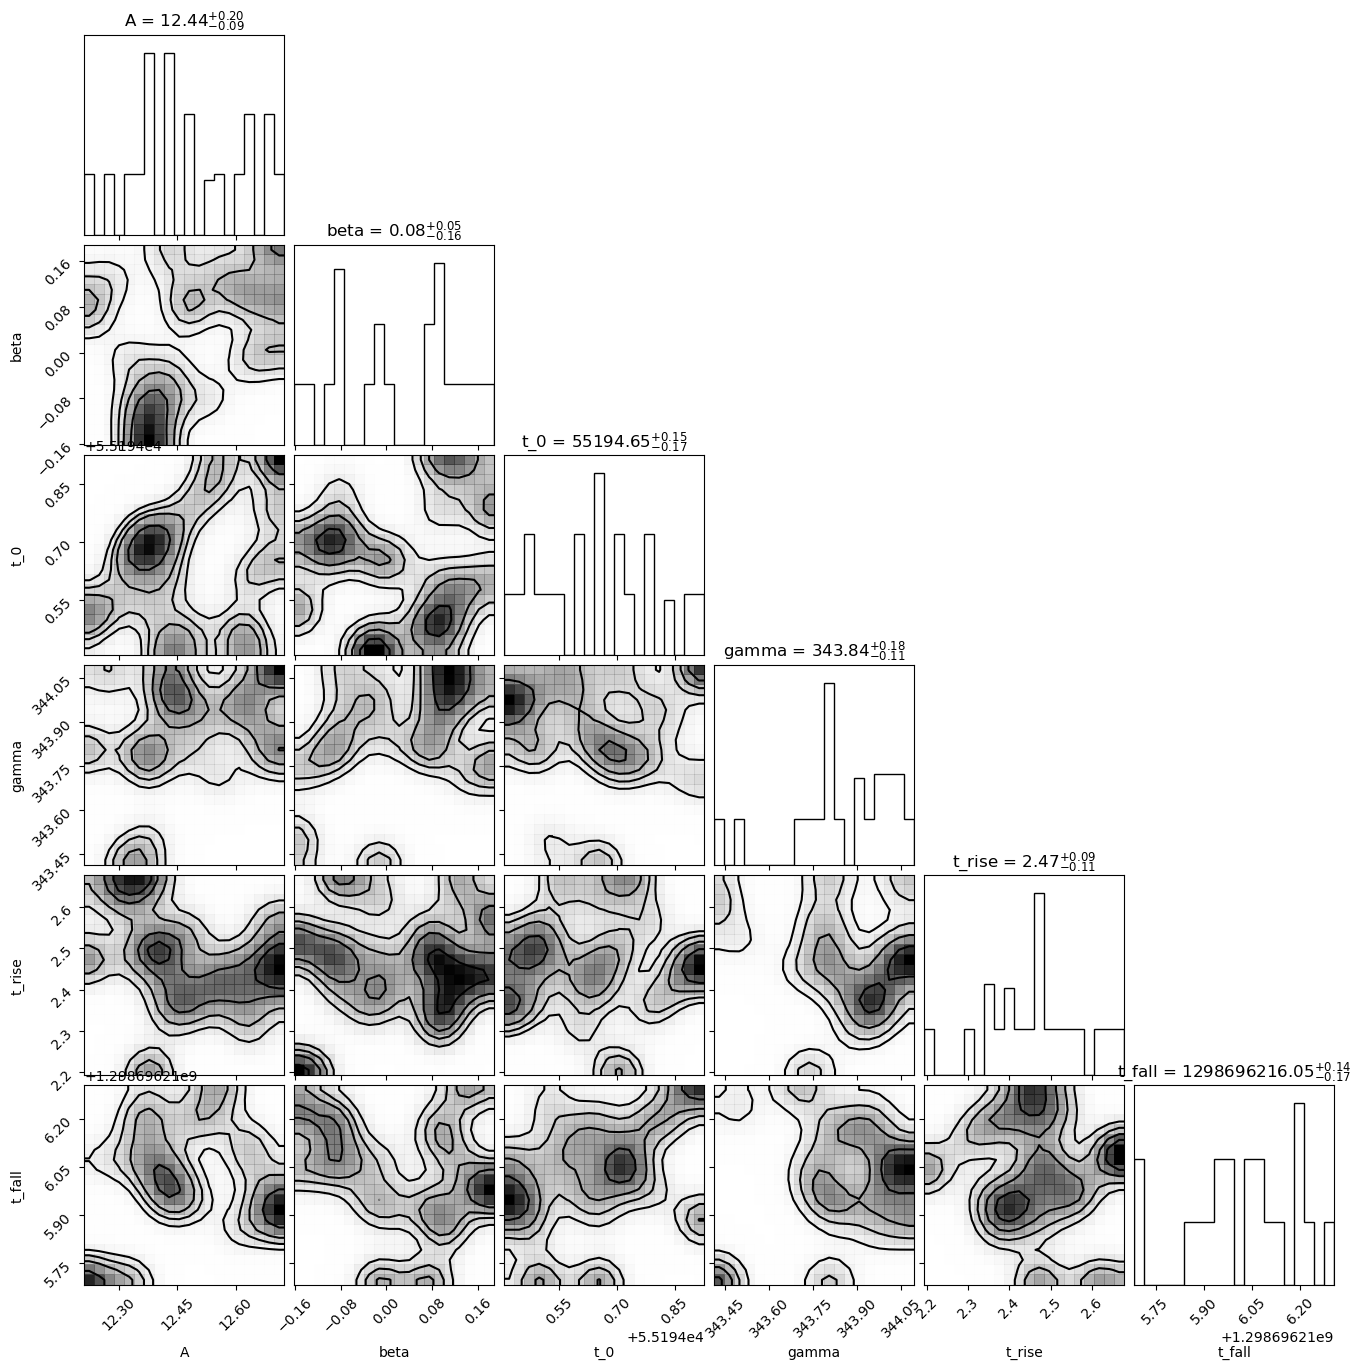

In [326]:
sample_z = sampler_z.chain
sample_z = sampler_z.chain[:, 1000:, :].reshape(-1, n_dim)
labels= ['A','beta','t_0','gamma','t_rise','t_fall']
fig = corner.corner(sample_z[1000::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)

In [328]:
# Get the median estimate for each parameter, and recreate the plot above from Ashley. 
#Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties

p_50_A_g = np.median(sample_g[1000::10,0])
p_50_beta_g = np.median(sample_g[1000::10,1])
p_50_t_0_g = np.median(sample_g[1000::10,2])
p_50_gamma_g = np.median(sample_g[1000::10,3])
p_50_t_rise_g = np.median(sample_g[1000::10,4])
p_50_t_fall_g = np.median(sample_g[1000::10,5])

p_50_A_r = np.median(sample_r[1000::10,0])
p_50_beta_r = np.median(sample_r[1000::10,1])
p_50_t_0_r = np.median(sample_r[1000::10,2])
p_50_gamma_r = np.median(sample_r[1000::10,3])
p_50_t_rise_r = np.median(sample_r[1000::10,4])
p_50_t_fall_r = np.median(sample_r[1000::10,5])

p_50_A_i = np.median(sample_i[1000::10,0])
p_50_beta_i = np.median(sample_i[1000::10,1])
p_50_t_0_i = np.median(sample_i[1000::10,2])
p_50_gamma_i = np.median(sample_i[1000::10,3])
p_50_t_rise_i = np.median(sample_i[1000::10,4])
p_50_t_fall_i = np.median(sample_i[1000::10,5])

p_50_A_z = np.median(sample_z[1000::10,0])
p_50_beta_z = np.median(sample_z[1000::10,1])
p_50_t_0_z = np.median(sample_z[1000::10,2])
p_50_gamma_z = np.median(sample_z[1000::10,3])
p_50_t_rise_z = np.median(sample_z[1000::10,4])
p_50_t_fall_z = np.median(sample_z[1000::10,5])

Text(0.5, 1.0, 'g-band data')

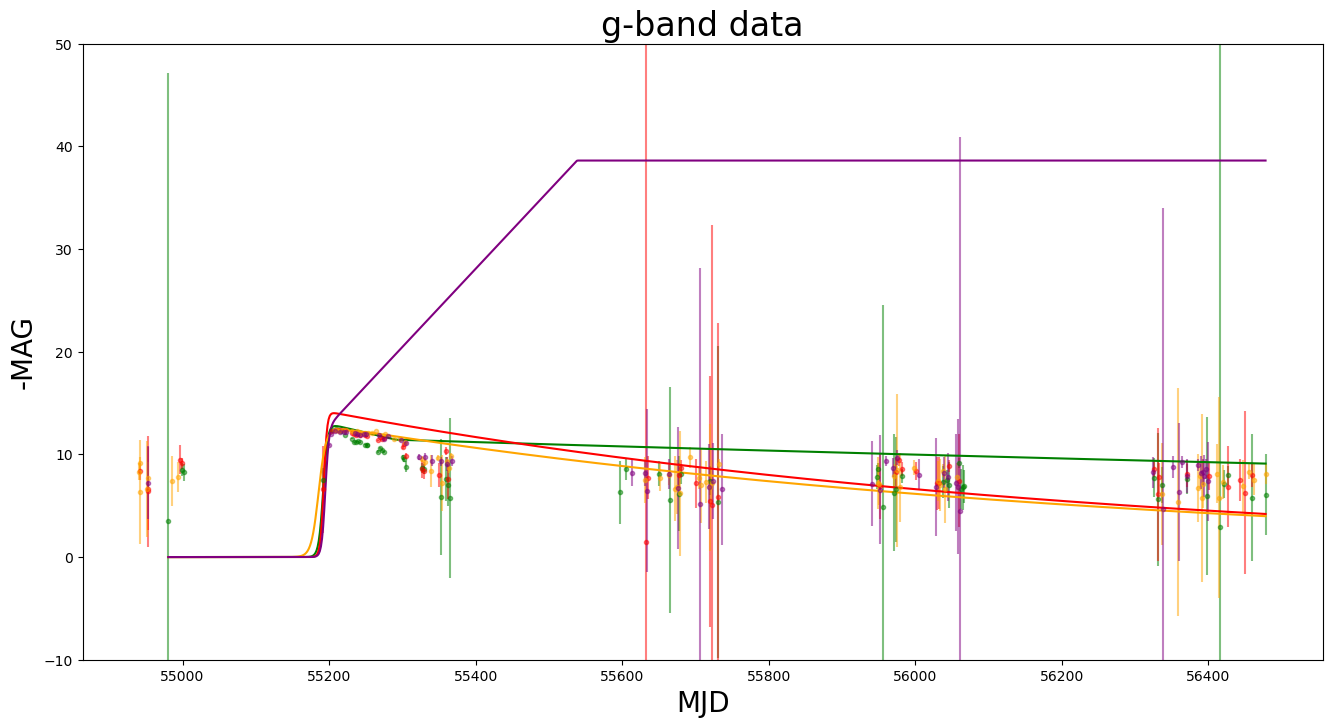

In [334]:
plt.figure(figsize=(16,8))
plt.errorbar(data_1_g['MJD'],-data_1_g['MAG'],yerr=data_1_g['MAGERR'],fmt='.',color='g',alpha=0.5)
plt.errorbar(data_1_r['MJD'],-data_1_r['MAG'],yerr=data_1_r['MAGERR'],fmt='.',color='r',alpha=0.5)
plt.errorbar(data_1_i['MJD'],-data_1_i['MAG'],yerr=data_1_i['MAGERR'],fmt='.',color='orange',alpha=0.5)
plt.errorbar(data_1_z['MJD'],-data_1_z['MAG'],yerr=data_1_z['MAGERR'],fmt='.',color='purple',alpha=0.5)

plt.plot(np.linspace(tmin,tmax,1000),villar_model(np.linspace(tmin,tmax,1000),p_50_A_g,p_50_beta_g,p_50_t_0_g
                                                  ,p_50_gamma_g,p_50_t_rise_g,p_50_t_fall_g),color='green',label='Emcee')
plt.plot(np.linspace(tmin,tmax,1000),villar_model(np.linspace(tmin,tmax,1000),p_50_A_r,p_50_beta_r,p_50_t_0_r
                                                  ,p_50_gamma_r,p_50_t_rise_r,p_50_t_fall_r),color='red',label='Emcee')
plt.plot(np.linspace(tmin,tmax,1000),villar_model(np.linspace(tmin,tmax,1000),p_50_A_i,p_50_beta_i,p_50_t_0_i
                                                  ,p_50_gamma_i,p_50_t_rise_i,p_50_t_fall_i),color='orange',label='Emcee')
plt.plot(np.linspace(tmin,tmax,1000),villar_model(np.linspace(tmin,tmax,1000),p_50_A_z,p_50_beta_z,p_50_t_0_z
                                                  ,p_50_gamma_z,p_50_t_rise_z,p_50_t_fall_z),color='purple',label='Emcee')
#plt.legend(loc='lower left',fontsize=16)
plt.xlabel('MJD',fontsize=20)
plt.ylabel('-MAG',fontsize=20)
plt.ylim(-10,50)
plt.title('g-band data',fontsize=24)